<a href="https://colab.research.google.com/github/RafaGusmao/Analise-Fatorial-PCA/blob/main/An%C3%A1lise_Fatorial_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats


In [24]:
# Carregar os dados, verificando o nome da coluna e delimitador
notasfatorial = pd.read_csv("/content/notasfatorial.csv", encoding="latin-1", sep=";")


print(notasfatorial.columns)

notasfatorial.set_index("estudante", inplace=True)

Index(['estudante', 'notas_financas', 'notas_custos', 'notas_marketing',
       'notas_atuarias'],
      dtype='object')


In [25]:
scaler = StandardScaler()
notasfatorial_std = pd.DataFrame(scaler.fit_transform(notasfatorial),
                                 index=notasfatorial.index,
                                 columns=notasfatorial.columns)


In [26]:
pca = PCA()
pca.fit(notasfatorial_std)

# Resumo da PCA
print(pd.DataFrame(pca.explained_variance_ratio_, columns=["Variância Explicada"]))


   Variância Explicada
0             0.629763
1             0.250102
2             0.074433
3             0.045702


In [27]:
# Desvios-padrão (raízes quadradas dos autovalores)
print("Desvios-Padrão dos Componentes Principais:", np.sqrt(pca.explained_variance_))

# Matriz de autovetores (loadings)
print("Autovetores (rotation):", pca.components_)

# Médias utilizadas na padronização
print("Médias das variáveis:", scaler.mean_)


Desvios-Padrão dos Componentes Principais: [1.59514815 1.00524286 0.54839717 0.42971357]
Autovetores (rotation): [[ 5.64123562e-01  5.88711204e-01 -2.66292456e-02  5.78337798e-01]
 [ 6.72773285e-03  4.87458333e-02  9.98736510e-01 -1.01962746e-02]
 [ 8.00695215e-01 -2.19795632e-01 -3.55517060e-04 -5.57294291e-01]
 [-2.01510588e-01  7.76358707e-01 -4.26161889e-02 -5.95688258e-01]]
Médias das variáveis: [5.834  4.7144 5.6674 5.314 ]


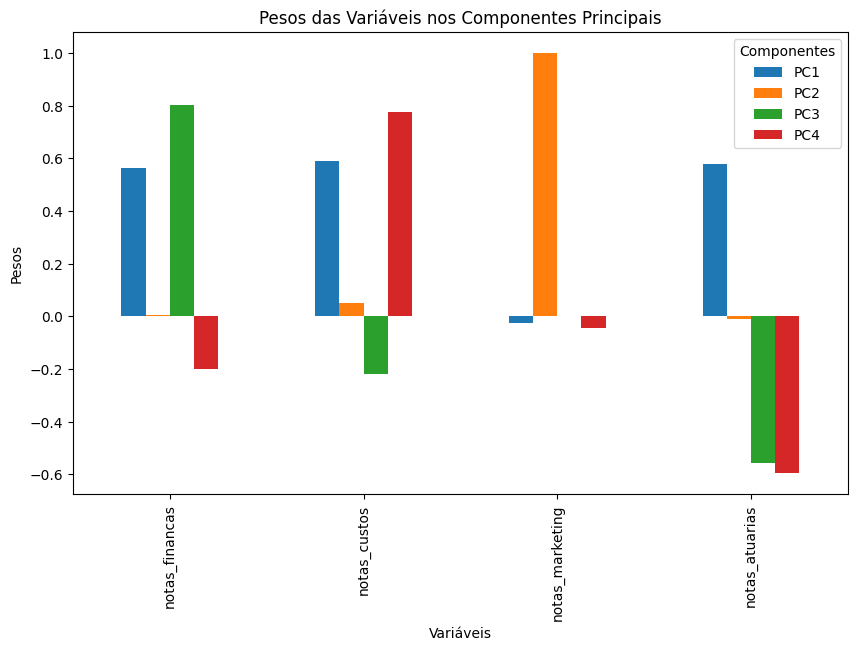

In [28]:
df_loadings = pd.DataFrame(pca.components_.T,
                           index=notasfatorial.columns,
                           columns=[f"PC{i+1}" for i in range(len(notasfatorial.columns))])

df_loadings.plot(kind="bar", figsize=(10, 6))
plt.title("Pesos das Variáveis nos Componentes Principais")
plt.xlabel("Variáveis")
plt.ylabel("Pesos")
plt.legend(title="Componentes")
plt.show()


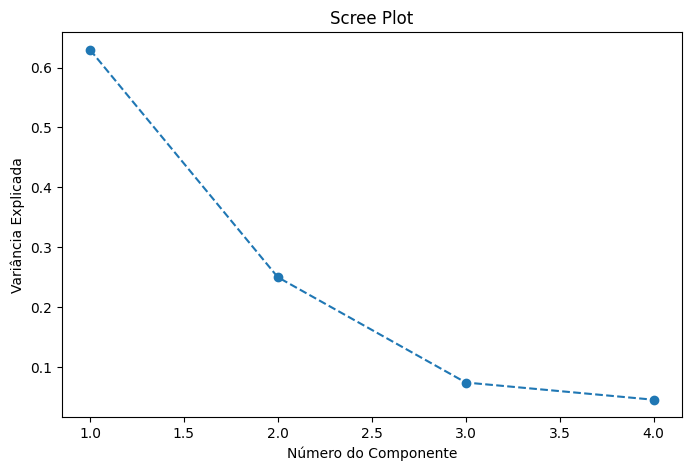

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker="o", linestyle="--")
plt.title("Scree Plot")
plt.xlabel("Número do Componente")
plt.ylabel("Variância Explicada")
plt.show()


In [30]:
num_comp = sum(pca.explained_variance_ > 1)
cargas_fatoriais = df_loadings.iloc[:, :num_comp] @ np.diag(np.sqrt(pca.explained_variance_[:num_comp]))

print(cargas_fatoriais)


                        0         1
notas_financas   0.899861  0.006763
notas_custos     0.939082  0.049001
notas_marketing -0.042478  1.003973
notas_atuarias   0.922534 -0.010250


In [31]:
comunalidades = (cargas_fatoriais ** 2).sum(axis=1)
print(comunalidades)


notas_financas     0.809795
notas_custos       0.884275
notas_marketing    1.009766
notas_atuarias     0.851175
dtype: float64


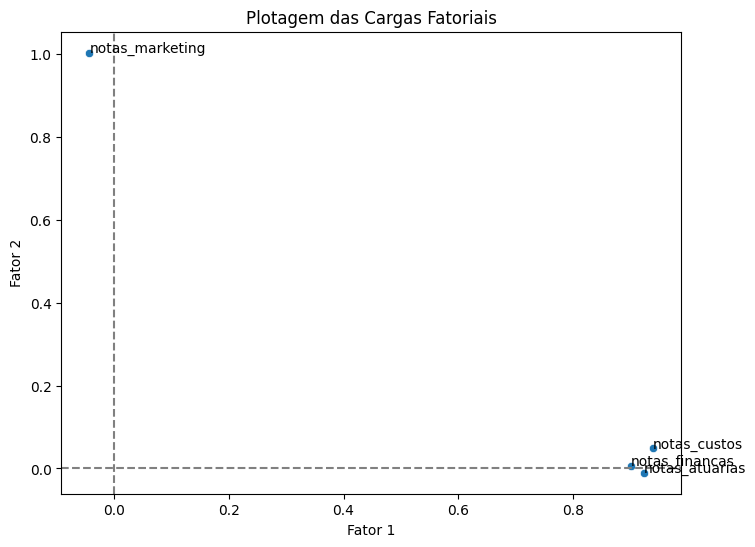

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=cargas_fatoriais.iloc[:, 0], y=cargas_fatoriais.iloc[:, 1])

for i, txt in enumerate(cargas_fatoriais.index):
    plt.annotate(txt, (cargas_fatoriais.iloc[i, 0], cargas_fatoriais.iloc[i, 1]))

plt.axhline(0, linestyle="dashed", color="gray")
plt.axvline(0, linestyle="dashed", color="gray")
plt.xlabel("Fator 1")
plt.ylabel("Fator 2")
plt.title("Plotagem das Cargas Fatoriais")
plt.show()


In [33]:
scores_fatoriais = pca.components_[:num_comp, :] / np.sqrt(pca.explained_variance_[:num_comp])[:, np.newaxis]
df_scores = pd.DataFrame(scores_fatoriais.T, index=notasfatorial.columns, columns=[f"F{i+1}" for i in range(num_comp)])

print(df_scores)


                       F1        F2
notas_financas   0.353650  0.006693
notas_custos     0.369064  0.048492
notas_marketing -0.016694  0.993528
notas_atuarias   0.362561 -0.010143


In [36]:
F1 = notasfatorial_std @ df_scores.iloc[:, 0]
F2 = notasfatorial_std @ df_scores.iloc[:, 1]

notasfatorial["Fator1"] = F1
notasfatorial["Fator2"] = F2  # Multiplicação por -1 como no R

# Criando a pontuação ponderada pela variância explicada
var_compartilhada = pca.explained_variance_ratio_[:num_comp]
notasfatorial["Pontuacao"] = notasfatorial["Fator1"] * var_compartilhada[0] + notasfatorial["Fator2"] * var_compartilhada[1]

# Ordenando por pontuação
ranking_final = notasfatorial.sort_values(by="Pontuacao", ascending=False)
print(ranking_final)


           notas_financas  notas_custos  notas_marketing  notas_atuarias  \
estudante                                                                  
Adelino               9.9         10.00             10.0            10.0   
Renata                7.7         10.00             10.0            10.0   
Cecília               9.8         10.00              7.0            10.0   
Felipe                8.7         10.00              9.0             9.0   
Giulia                6.2         10.00             10.0            10.0   
...                   ...           ...              ...             ...   
Ester                 0.6          1.94              3.0             3.2   
Carolina              3.1          2.00              2.0             2.0   
Elaine                3.1          2.00              2.0             2.0   
Viviane               0.7          1.87              2.8             2.8   
Gilmar                1.1          1.85              1.7             1.7   

           

In [37]:
ranking_final


,notas_financas,notas_custos,notas_marketing,notas_atuarias,Fator1,Fator2,Pontuacao
estudante,,,,,,,
Adelino,9.9,10.00,10.0,10.0,1.914146,1.624030,1.611632
Renata,7.7,10.00,10.0,10.0,1.663742,1.619292,1.452752
Cecília,9.8,10.00,7.0,10.0,1.920559,0.564763,1.350746
Felipe,8.7,10.00,9.0,9.0,1.638498,1.272485,1.350116
Giulia,6.2,10.00,10.0,10.0,1.493012,1.616061,1.344424
...,...,...,...,...,...,...,...
Ester,0.6,1.94,3.0,3.2,-1.305093,-0.999345,-1.071838
Carolina,3.1,2.00,2.0,2.0,-1.179553,-1.340920,-1.078206
Elaine,3.1,2.00,2.0,2.0,-1.179553,-1.340920,-1.078206
